<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pickle
import pandas as pd
import numpy as np
! pip install tsaug
import tsaug

# Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle") # read pickle file
#labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    # Import libraries
    import matplotlib.pyplot as plt
    
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

In [3]:
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
  '''
  What does this function do?
  val_data: validation data generator
  test_data: testing data generator
  '''
  # Evaluate the model
  from tensorflow.keras.models import load_model
  import joblib

  # Load the model
  model = load_model(model_filepath)
  model_eval_val = model.evaluate(val_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  
  # Load the training fit history
  fit_history = joblib.load(history_filepath) # read pickle file

  # Make Plot of Training Fit
  plot_evaluation(fit_history, save_plot_path)

  # Print validation and testing metrics
  print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
  model_eval_test = model.evaluate(test_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
  return model, fit_history

In [4]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [5]:
data[0].describe()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
count,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06
mean,1.479597e+01,8.773488e-07,9.201702e+01,3.477422e+01,1.319141e-01
std,5.429806e+00,5.118602e-03,1.541436e+01,4.796361e-01,3.383974e-01
min,2.319673e+00,-5.590441e-02,5.391528e+01,3.365948e+01,0.000000e+00
25%,1.046479e+01,-1.277041e-03,7.972357e+01,3.438724e+01,0.000000e+00
50%,1.530387e+01,-6.004727e-05,9.191419e+01,3.461252e+01,0.000000e+00
75%,1.836961e+01,1.148620e-03,1.021086e+02,3.526480e+01,0.000000e+00
max,5.166052e+01,9.205739e-02,1.527273e+02,3.577805e+01,1.000000e+00


In [6]:
'''
engineer features that capture the patterns in your data that are relevant to 
predicting stress, you can compute statistics over different time intervals.
function compute_features that computes the mean and standard deviation of EDA 
over different time intervals using the rolling function. We then apply this 
function to each dataframe in the list using a list comprehension.
'''
# Define a function to compute features
def compute_features(df):
   # Windows in samples: 1-minute, 5-minute, 10-minute
    #windows = [int(60 * 700), int(300 * 700), int(600 * 700)]  

    #for window in windows:
    #    for col in ['RSP_Phase', 'EDA_Phasic', 'ECG_Rate', 'Temp']:
    #        df[f'{col}_mean_{window // 700}s'] = df[col].rolling(window=window).mean()
    #        df[f'{col}_std_{window // 700}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    #df.dropna(inplace=True)

    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df) for df in data]


In [7]:
data_frames_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [8]:
data_frames_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3847200.0,1.479597e+01,5.429806,2.319673,10.464794,15.303869,18.369611,51.660517
EDA_Phasic,3847200.0,8.773488e-07,0.005119,-0.055904,-0.001277,-0.000060,0.001149,0.092057
ECG_Rate,3847200.0,9.201702e+01,15.414356,53.915276,79.723566,91.914189,102.108630,152.727273
Temp,3847200.0,3.477422e+01,0.479636,33.659485,34.387238,34.612518,35.264801,35.778046
label,3847200.0,1.319141e-01,0.338397,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
data_frames_list[0].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
0,14.481092,-0.002589,91.999226,33.695862,0
1,14.481092,-0.002616,91.999226,33.741333,0
2,14.481092,-0.002641,91.999226,33.717072,0
3,14.481092,-0.002665,91.999226,33.741333,0
4,14.481092,-0.002688,91.999226,33.747406,0


In [10]:
## Include Subject
for i, df in enumerate(data):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

                   

In [11]:
df.head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,subject
0,12.355807,-0.073479,78.884373,33.682251,0,14
1,12.355807,-0.073444,78.884373,33.704956,0,14
2,12.355807,-0.073410,78.884373,33.700439,0,14
3,12.355807,-0.073376,78.884373,33.689789,0,14
4,12.355807,-0.073342,78.884373,33.656464,0,14


In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Concatenate the dataframes together
df = pd.concat(data_frames_list)

# Downsample the dataframe
target_hz = 1
resample_factor = int(700 / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Select 80% of subjects for training
train_subjects = df['subject'].unique()[:int(0.8 * len(df['subject'].unique()))]

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

for i, group in df.groupby('subject'):
    if i in train_subjects:
        train, test = train_test_split(group, test_size=0.2, random_state=42)
        train, val = train_test_split(train, test_size=0.2, random_state=42)
        
        train_dfs.append(train)
        test_dfs.append(test)
        val_dfs.append(val)
    else:
        test_dfs.append(group)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)
val_df = pd.concat(val_dfs)

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')


In [121]:
train_df.head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,subject
897400,0.012998,0.010524,1.164661,0.651648,0,0
714700,-0.186213,-0.009418,0.676079,0.503389,0,0
1584800,-0.719587,-0.011373,-0.714566,0.627127,0,0
1283100,0.425865,-0.009946,0.365347,0.521433,0,0
1808100,-1.486073,0.030512,-0.494320,0.881826,0,0


<Axes: >

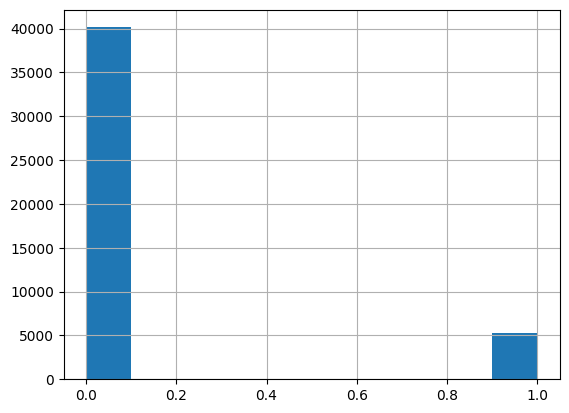

In [122]:
train_df['label'].hist()

In [123]:
len(train_df)// 600

75

In [124]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tsaug import TimeWarp, Drift, AddNoise

class AugmentedTimeseriesGenerator(Sequence):
    def __init__(self, x, y, batch_size, length, augmenter=None):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.length = length
        self.augmenter = augmenter

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        x_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size:(index+1)*self.batch_size]
        if self.augmenter and self.batch_size == 1:
            x_batch = self.augmenter.augment(x_batch)
        return x_batch, y_batch

# Define batch size and sequence length
duration = 5 # minutes
target_hz = 1
seq_length = target_hz * 60 * duration # full length of sequence
batch_size = len(train_df) // seq_length

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Reshape the data to have shape (N, T, C)
print(batch_size)
max_batches = len(train_df) // batch_size
print(max_batches)
train_data = train_df[:batch_size*seq_length].values
print(train_data.shape)

# Drop subject ID and label columns
train_data = train_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values
val_data = val_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values
test_data = test_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values

# Reshape the data to have shape (N, T, C)
train_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)
val_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)
test_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)

# Define augmentation functions
augmenter = (
    TimeWarp() * 5
    + Drift(max_drift=(0.1, 0.5)) @ 0.8
    + AddNoise(scale=0.01)
)

train_gen = AugmentedTimeseriesGenerator(train_data, 
                                         train_df['label'].values,
                                         batch_size=batch_size, 
                                         length=seq_length,
                                         #augmenter=augmenter
                                         )

val_gen = AugmentedTimeseriesGenerator(val_data, 
                                       val_df['label'].values,
                                       batch_size=batch_size, 
                                       length=seq_length)

test_gen = AugmentedTimeseriesGenerator(test_data, 
                                        test_df['label'].values,
                                        batch_size=batch_size, 
                                        length=seq_length)

151
300
(45300, 6)


In [125]:
# get the first batch of data
x_train_batch, y_train_batch = train_gen[0]
x_val_batch, y_val_batch = val_gen[0]
x_test_batch, y_test_batch = test_gen[0]

# check the shape of the input batch
print(x_train_batch.shape)
print(x_val_batch.shape)
print(x_test_batch.shape)

(151, 300, 4)
(151, 300, 4)
(151, 300, 4)


In [126]:
# Assuming you have defined a TimeseriesGenerator called 'train_gen'

# Get the targets for the first batch of the generator
batch_x, batch_y = train_gen[0]

# 'batch_y' contains the targets for the batch, which can be accessed as follows:
for e in batch_y:
  print(e)


0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


In [127]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

Class 0 (Non-stress): 86.75%
Class 1 (Stress): 13.25%


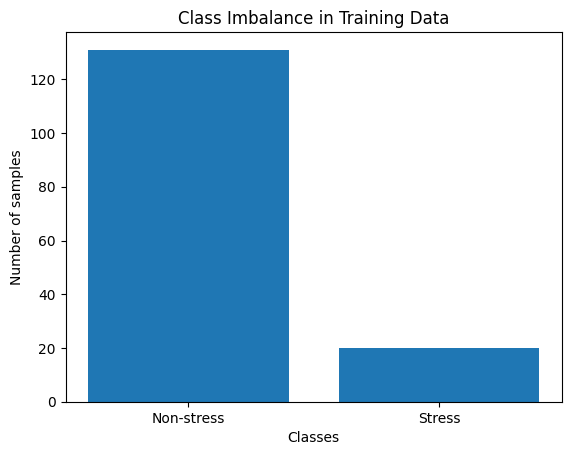

In [170]:
# Class imbalance

# Class weight correction
from sklearn.utils import class_weight

y_train = np.concatenate([train_gen[i][1] for i in range(len(train_gen))])

import matplotlib.pyplot as plt
import numpy as np

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced', 
                                                   y=y_train)

# Define class weight dictionary
zero_count = class_counts[0]
one_count = class_counts[1]
class_weights_dict = {0: 1 / zero_count, 1: 1 / one_count}

#class_weights_dict = {class_label: class_weight
#                      for class_label, class_weight in zip(unique_classes,  len(y_train) / (2*class_counts))}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.show()

In [171]:
def confusion_matrix_plot(model, data, save_file=None):
    # Confusion Matrix
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)

    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if save_file:
        plt.savefig(f'{save_file}')
    plt.show()


In [172]:
# Classification Report
from sklearn.metrics import classification_report

def classification_report_output(model, data, save_file=None):
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    if save_file:
        report_df.to_csv(save_file, index=True)

    print(report_df)

In [173]:
print(train_gen[0][0].shape)
# get the first batch of data
x_batch, y_batch = train_gen[0]

# check the shape of the input batch
print(x_batch.shape)

(151, 300, 4)
(151, 300, 4)


In [174]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
x = Flatten()(inputs)
x = Dense(batch_size, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 1200)              0         
                                                                 
 dense_19 (Dense)            (None, 151)               181351    
                                                                 
 dense_20 (Dense)            (None, 1)                 152       
                                                                 
Total params: 181,503
Trainable params: 181,503
Non-trainable params: 0
_________________________________________________________________


In [175]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [176]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=5),
                        # remove the last batch if not even
                        #steps_per_epoch=len(train_gen)-1
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.0896 - binary_accuracy: 0.8278 - val_loss: 3.3175 - val_binary_accuracy: 0.6689
Epoch 2/200
1/1 [==============================] - 0s 207ms/step - loss: 0.0589 - binary_accuracy: 0.7351 - val_loss: 5.1774 - val_binary_accuracy: 0.5828
Epoch 3/200
1/1 [==============================] - 0s 168ms/step - loss: 0.0635 - binary_accuracy: 0.6490 - val_loss: 5.7476 - val_binary_accuracy: 0.5298
Epoch 4/200
1/1 [==============================] - 0s 192ms/step - loss: 0.0671 - binary_accuracy: 0.6093 - val_loss: 5.7721 - val_binary_accuracy: 0.5364
Epoch 5/200
1/1 [==============================] - 0s 170ms/step - loss: 0.0673 - binary_accuracy: 0.6026 - val_loss: 5.8062 - val_binary_accuracy: 0.5563
Epoch 6/200
1/1 [==============================] - 0s 191ms/step - loss: 0.0667 - binary_accuracy: 0.6225 - val_loss: 5.7590 - val_binary_accuracy: 0.5828
Epoch 6: early stopping


1/1 [==============================] - 0s 336ms/step - loss: 3.3175 - binary_accuracy: 0.6689


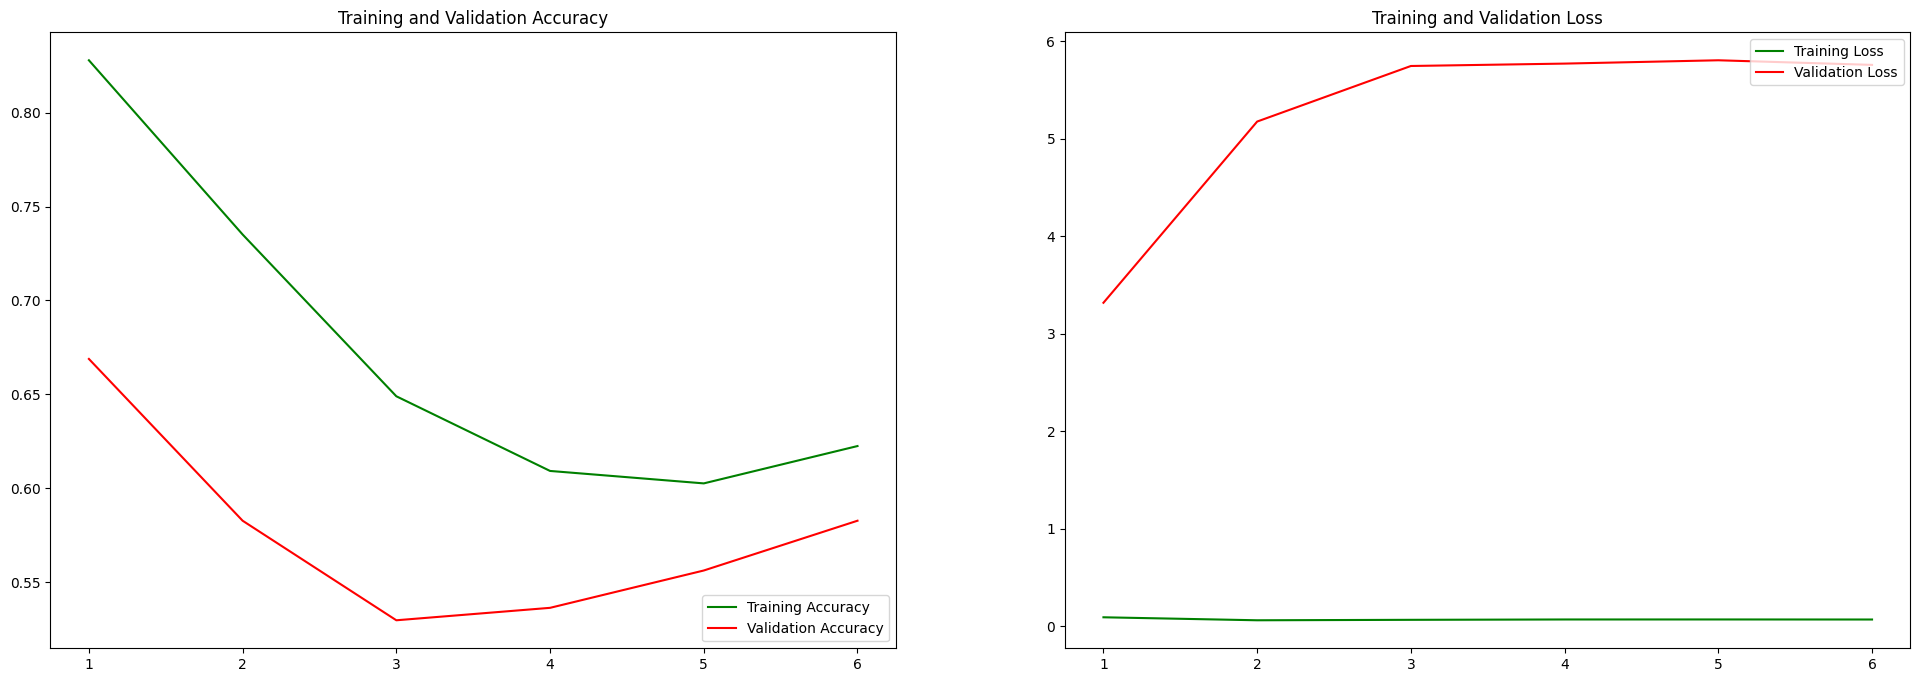

Validation Binary Accuracy is: 0.67
1/1 [==============================] - 0s 237ms/step - loss: 3.0429 - binary_accuracy: 0.6755
Testing Binary Accuracy is: 0.68


In [177]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

1/1 [==============================] - 0s 71ms/step


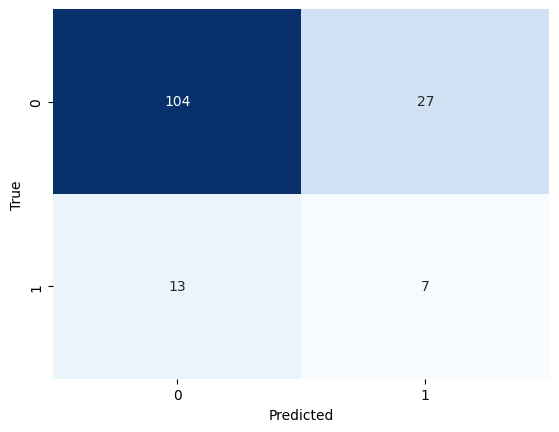

1/1 [==============================] - 0s 34ms/step
              precision    recall  f1-score     support
0              0.888889  0.793893  0.838710  131.000000
1              0.205882  0.350000  0.259259   20.000000
accuracy       0.735099  0.735099  0.735099    0.735099
macro avg      0.547386  0.571947  0.548984  151.000000
weighted avg   0.798424  0.735099  0.761961  151.000000
1/1 [==============================] - 0s 32ms/step


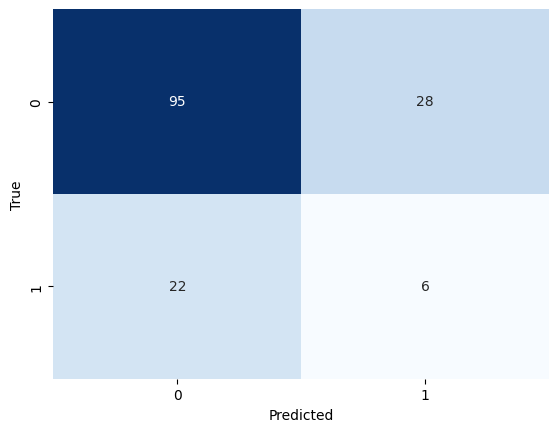

1/1 [==============================] - 0s 38ms/step
              precision    recall  f1-score     support
0              0.811966  0.772358  0.791667  123.000000
1              0.176471  0.214286  0.193548   28.000000
accuracy       0.668874  0.668874  0.668874    0.668874
macro avg      0.494218  0.493322  0.492608  151.000000
weighted avg   0.694126  0.668874  0.680757  151.000000
1/1 [==============================] - 0s 31ms/step


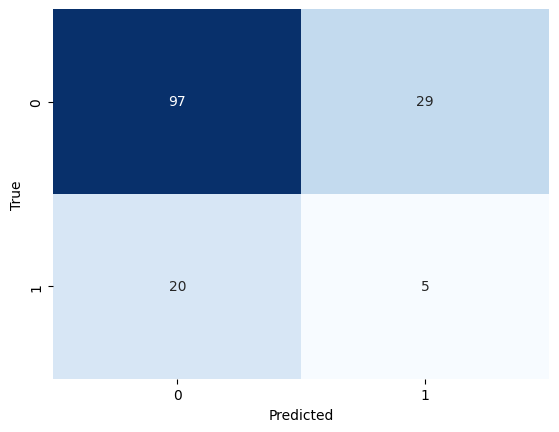

1/1 [==============================] - 0s 35ms/step
              precision    recall  f1-score     support
0              0.829060  0.769841  0.798354  126.000000
1              0.147059  0.200000  0.169492   25.000000
accuracy       0.675497  0.675497  0.675497    0.675497
macro avg      0.488059  0.484921  0.483923  151.000000
weighted avg   0.716146  0.675497  0.694238  151.000000


In [178]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [179]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


In [180]:
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [181]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [182]:

lstm_units_list = [32]
learning_rates_list = [0.0001, 0.001, 0.01]
class_weight_penalty= [1]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 lstm_14 (LSTM)              (None, 32)                4736      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.0094 - binary_accuracy: 0.5695 - val_loss: 0.7049 - val_binary_accuracy: 0.5894
Epoch 2/200
1/1 [==============================] - 0s 233ms/step - loss: 0.0093 - binary_accuracy: 0.5430 - val

1/1 [==============================] - 1s 676ms/step - loss: 0.6852 - binary_accuracy: 0.4967


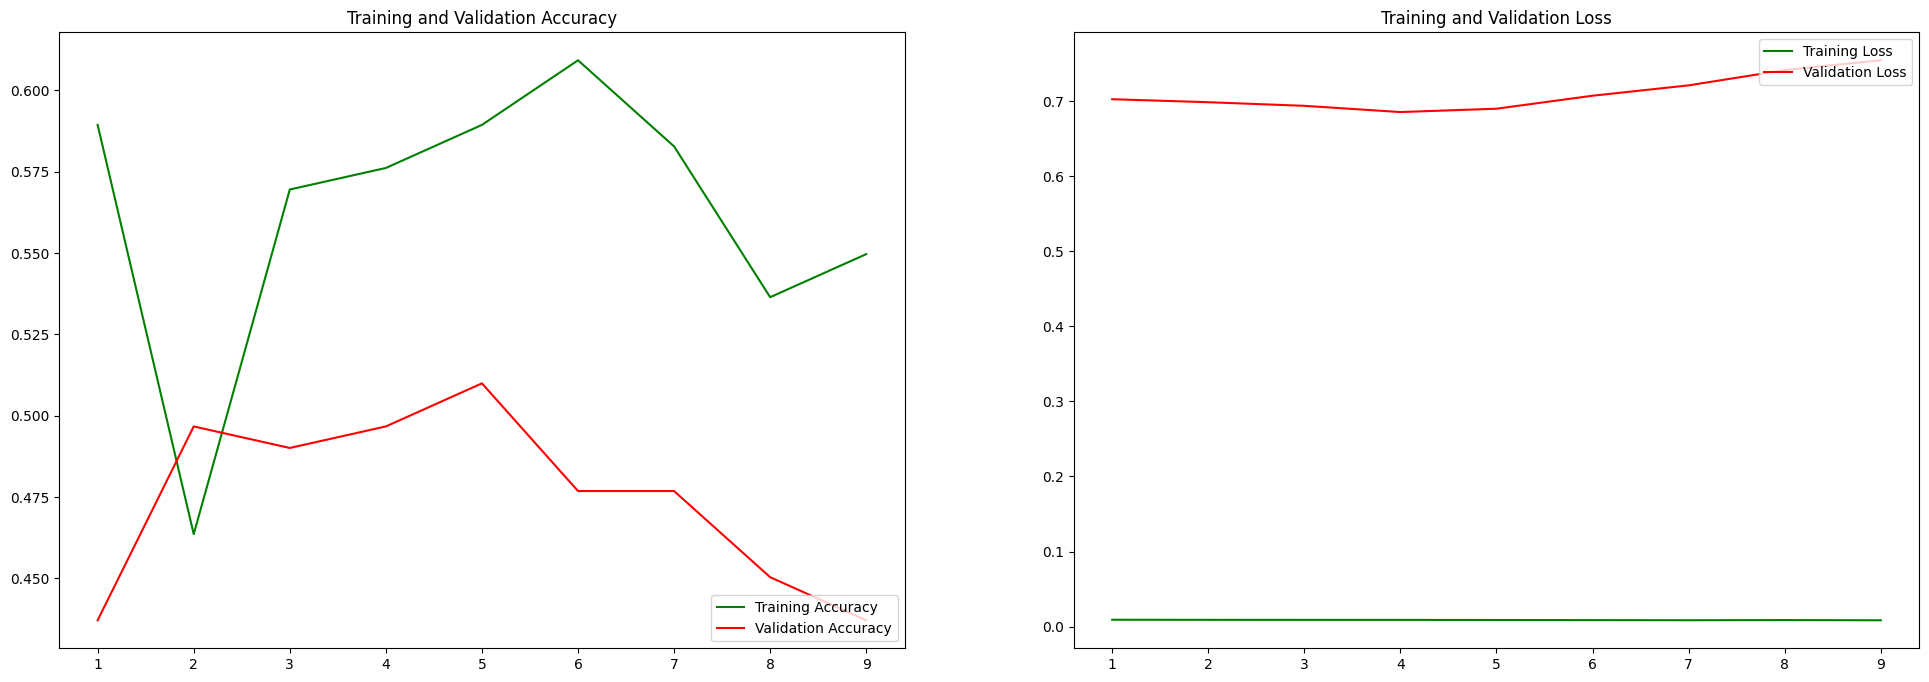

Validation Binary Accuracy is: 0.50
1/1 [==============================] - 0s 238ms/step - loss: 0.6842 - binary_accuracy: 0.5298
Testing Binary Accuracy is: 0.53


In [183]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

1/1 [==============================] - 0s 389ms/step


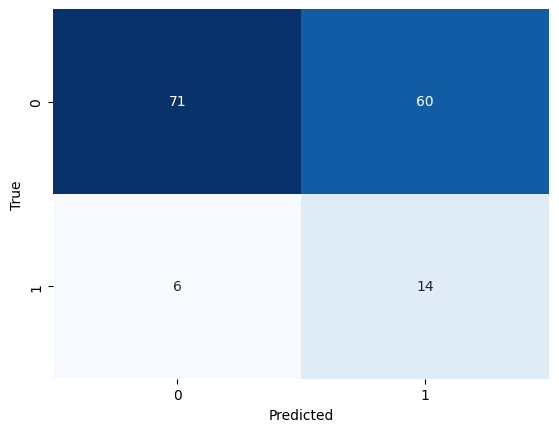

1/1 [==============================] - 0s 36ms/step
              precision    recall  f1-score     support
0              0.922078  0.541985  0.682692  131.000000
1              0.189189  0.700000  0.297872   20.000000
accuracy       0.562914  0.562914  0.562914    0.562914
macro avg      0.555634  0.620992  0.490282  151.000000
weighted avg   0.825007  0.562914  0.631723  151.000000
1/1 [==============================] - 0s 34ms/step


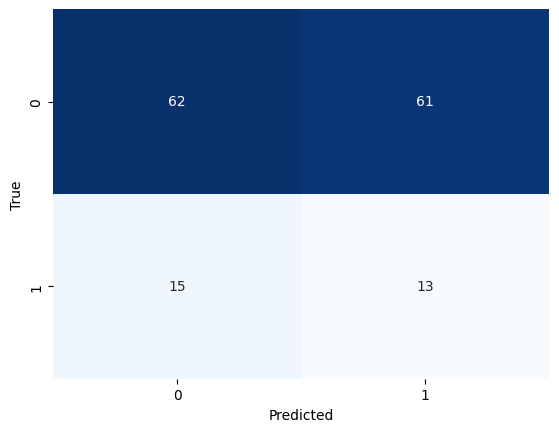

1/1 [==============================] - 0s 43ms/step
              precision    recall  f1-score     support
0              0.805195  0.504065  0.620000  123.000000
1              0.175676  0.464286  0.254902   28.000000
accuracy       0.496689  0.496689  0.496689    0.496689
macro avg      0.490435  0.484175  0.437451  151.000000
weighted avg   0.688463  0.496689  0.552300  151.000000
1/1 [==============================] - 0s 38ms/step


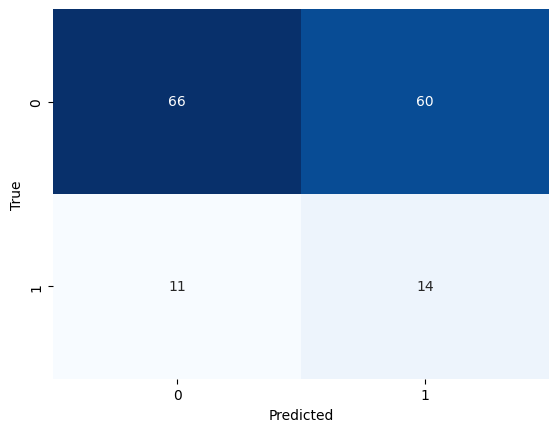

1/1 [==============================] - 0s 38ms/step
              precision    recall  f1-score     support
0              0.857143  0.523810  0.650246  126.000000
1              0.189189  0.560000  0.282828   25.000000
accuracy       0.529801  0.529801  0.529801    0.529801
macro avg      0.523166  0.541905  0.466537  151.000000
weighted avg   0.746555  0.529801  0.589416  151.000000


In [184]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

In [185]:
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, train_gen[0][0].shape[2]),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2, 
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [186]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
lstm_units_list = [best_lstm_units]
learning_rates_list = [best_learning_rate]
class_weight_penalty= [best_penalty]

In [187]:
print(lstm_units_list)
print(learning_rates_list)
print(class_weight_penalty)

[32]
[0.0001]
[1]


In [188]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 lstm_17 (LSTM)              (None, 300, 32)           4736      
                                                                 
 lstm_18 (LSTM)              (None, 16)                3136      
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 7,889
Trainable params: 7,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0092 - binary_accuracy: 0.4768 - val_loss: 0.6997 - val_bin

1/1 [==============================] - 1s 1s/step - loss: 0.6964 - binary_accuracy: 0.5033


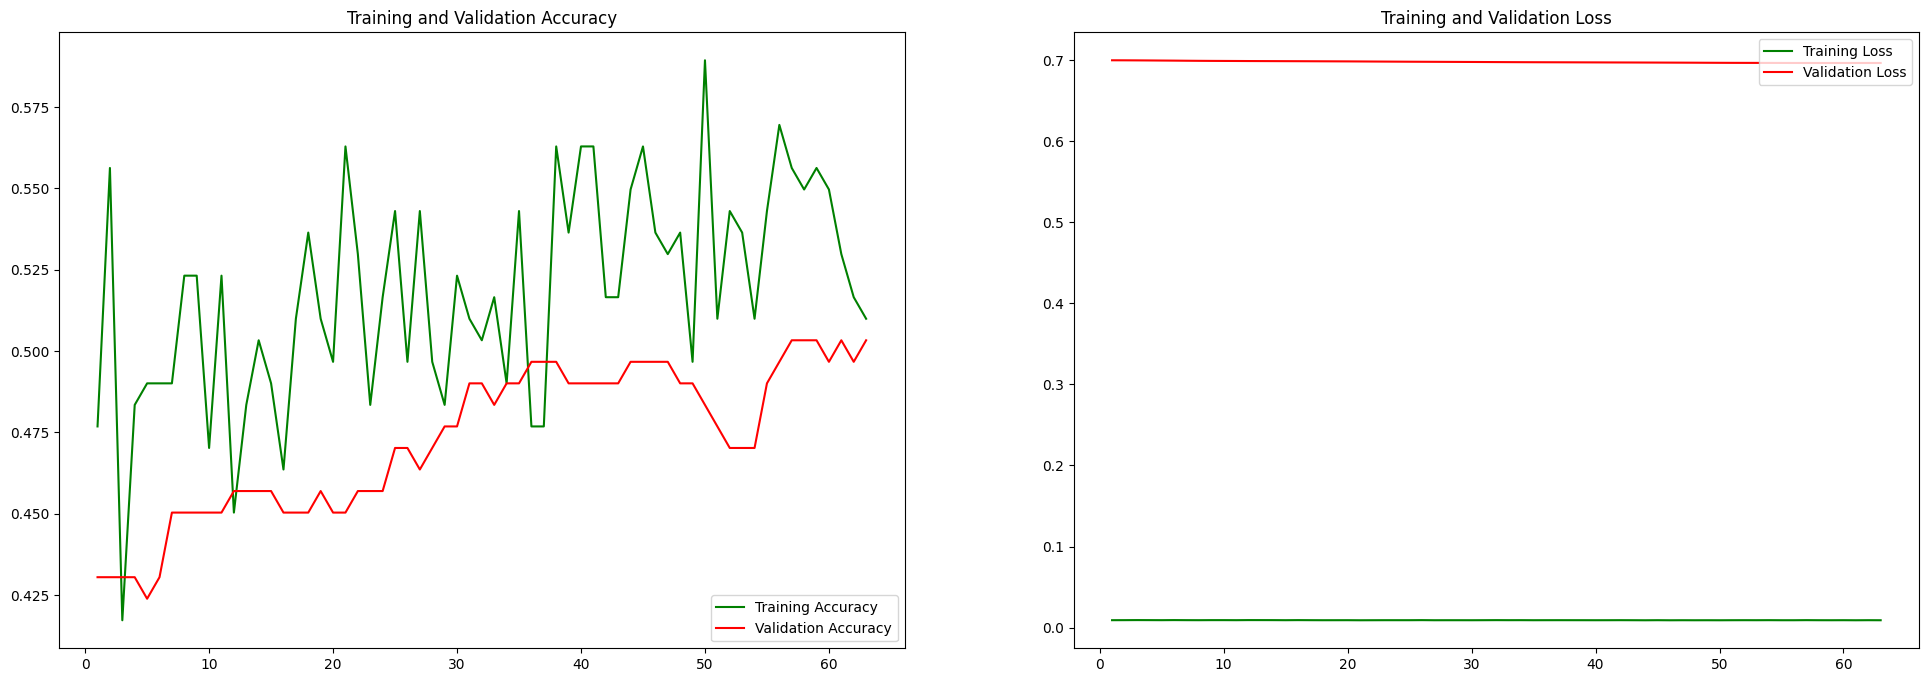

Validation Binary Accuracy is: 0.50
1/1 [==============================] - 0s 245ms/step - loss: 0.6935 - binary_accuracy: 0.4834
Testing Binary Accuracy is: 0.48


In [189]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

1/1 [==============================] - 1s 658ms/step


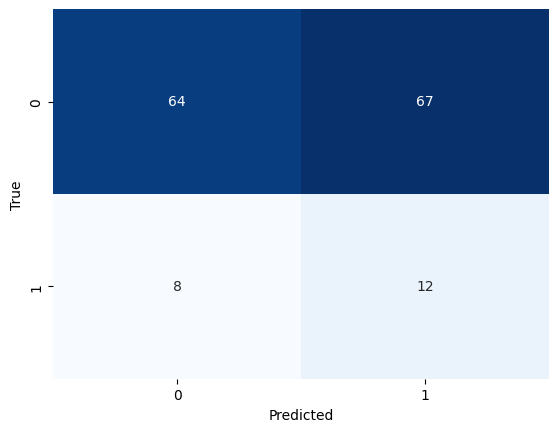

1/1 [==============================] - 0s 43ms/step
              precision    recall  f1-score     support
0              0.888889  0.488550  0.630542  131.000000
1              0.151899  0.600000  0.242424   20.000000
accuracy       0.503311  0.503311  0.503311    0.503311
macro avg      0.520394  0.544275  0.436483  151.000000
weighted avg   0.791274  0.503311  0.579136  151.000000
1/1 [==============================] - 0s 42ms/step


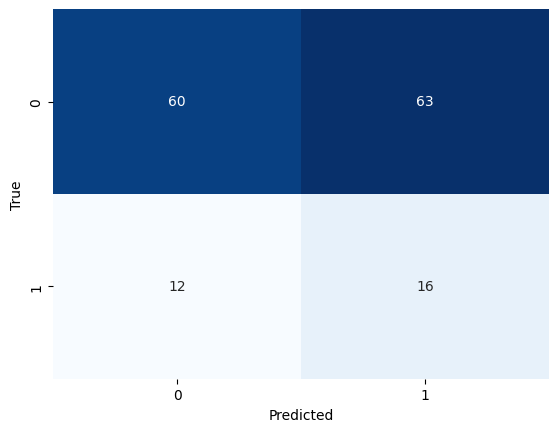

1/1 [==============================] - 0s 49ms/step
              precision    recall  f1-score     support
0              0.833333  0.487805  0.615385  123.000000
1              0.202532  0.571429  0.299065   28.000000
accuracy       0.503311  0.503311  0.503311    0.503311
macro avg      0.517932  0.529617  0.457225  151.000000
weighted avg   0.716363  0.503311  0.556729  151.000000
1/1 [==============================] - 0s 42ms/step


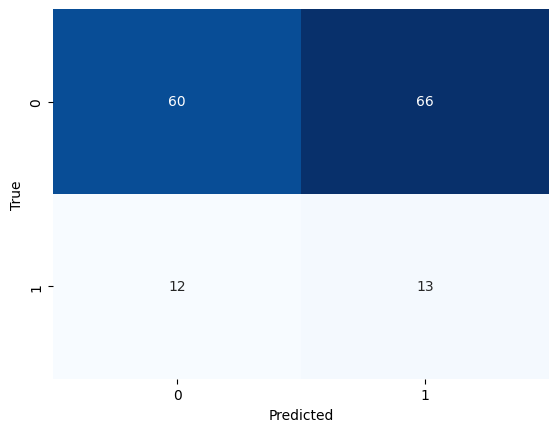

1/1 [==============================] - 0s 53ms/step
              precision    recall  f1-score     support
0              0.833333  0.476190  0.606061  126.000000
1              0.164557  0.520000  0.250000   25.000000
accuracy       0.483444  0.483444  0.483444    0.483444
macro avg      0.498945  0.498095  0.428030  151.000000
weighted avg   0.722609  0.483444  0.547110  151.000000


In [190]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

In [191]:
# Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, train_gen[0][0].shape[2]),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [192]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [193]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 lstm_19 (LSTM)              (None, 300, 32)           4736      
                                                                 
 batch_normalization_4 (Batc  (None, 300, 32)          128       
 hNormalization)                                                 
                                                                 
 lstm_20 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 

1/1 [==============================] - 1s 1s/step - loss: 0.7051 - binary_accuracy: 0.4503


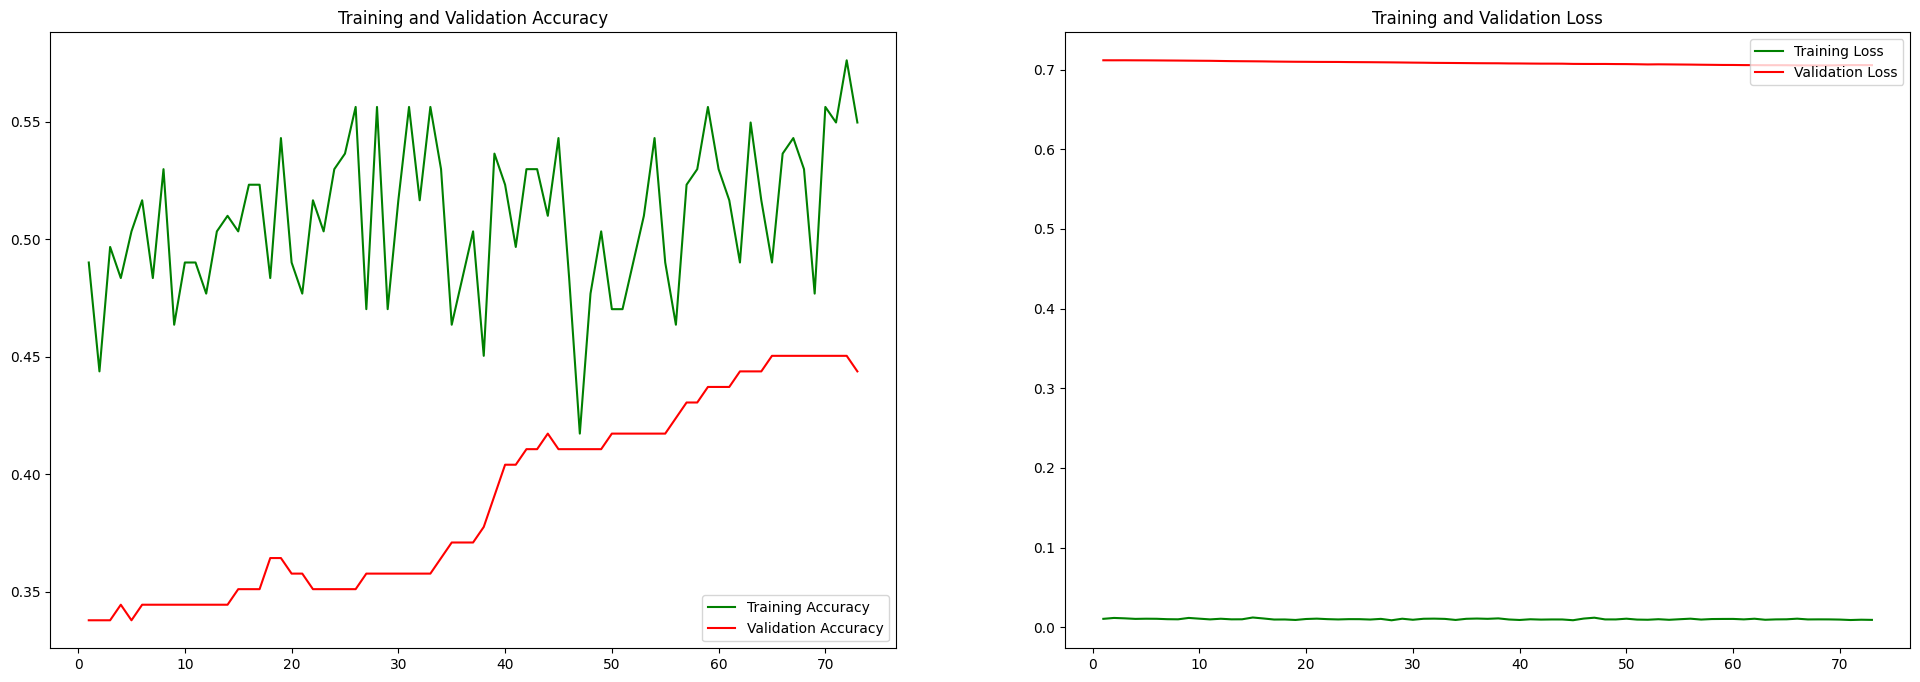

Validation Binary Accuracy is: 0.45
1/1 [==============================] - 0s 250ms/step - loss: 0.7029 - binary_accuracy: 0.4437
Testing Binary Accuracy is: 0.44


In [194]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

1/1 [==============================] - 1s 723ms/step


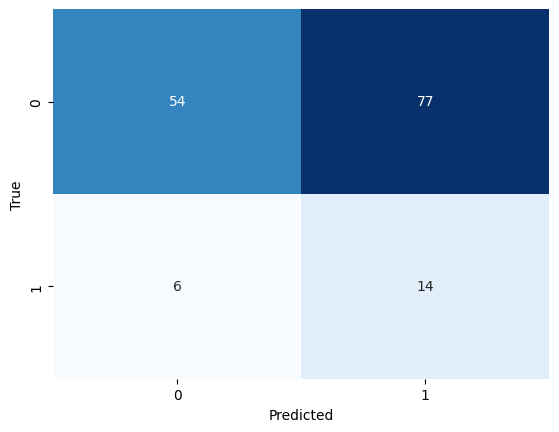

1/1 [==============================] - 0s 42ms/step
              precision    recall  f1-score     support
0              0.900000  0.412214  0.565445  131.000000
1              0.153846  0.700000  0.252252   20.000000
accuracy       0.450331  0.450331  0.450331    0.450331
macro avg      0.526923  0.556107  0.408849  151.000000
weighted avg   0.801172  0.450331  0.523963  151.000000
1/1 [==============================] - 0s 41ms/step


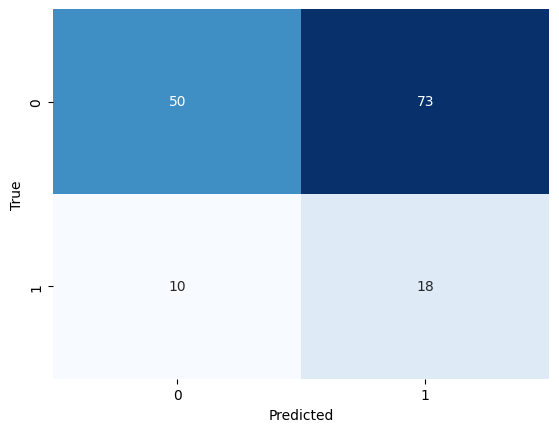

1/1 [==============================] - 0s 40ms/step
              precision    recall  f1-score     support
0              0.833333  0.406504  0.546448  123.000000
1              0.197802  0.642857  0.302521   28.000000
accuracy       0.450331  0.450331  0.450331    0.450331
macro avg      0.515568  0.524681  0.424485  151.000000
weighted avg   0.715487  0.450331  0.501217  151.000000
1/1 [==============================] - 0s 41ms/step


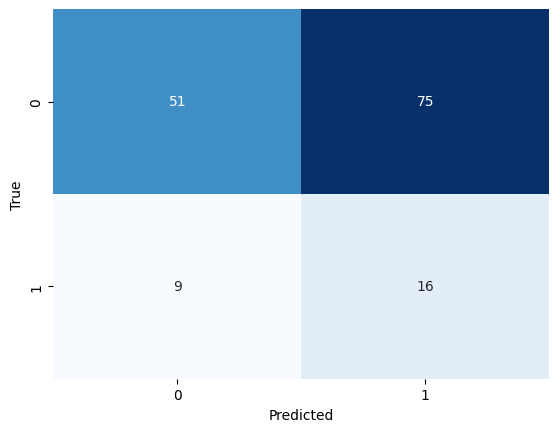

1/1 [==============================] - 0s 42ms/step
              precision    recall  f1-score     support
0              0.850000  0.404762  0.548387  126.000000
1              0.175824  0.640000  0.275862   25.000000
accuracy       0.443709  0.443709  0.443709    0.443709
macro avg      0.512912  0.522381  0.412125  151.000000
weighted avg   0.738381  0.443709  0.503267  151.000000


In [195]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

In [196]:
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=9, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=9, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(27, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [197]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [198]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 9)            333       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 9)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 9)            252       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 75, 9)            0         
 1D)                                                             
                                                                 
 

1/1 [==============================] - 1s 731ms/step - loss: 0.6318 - binary_accuracy: 0.8146


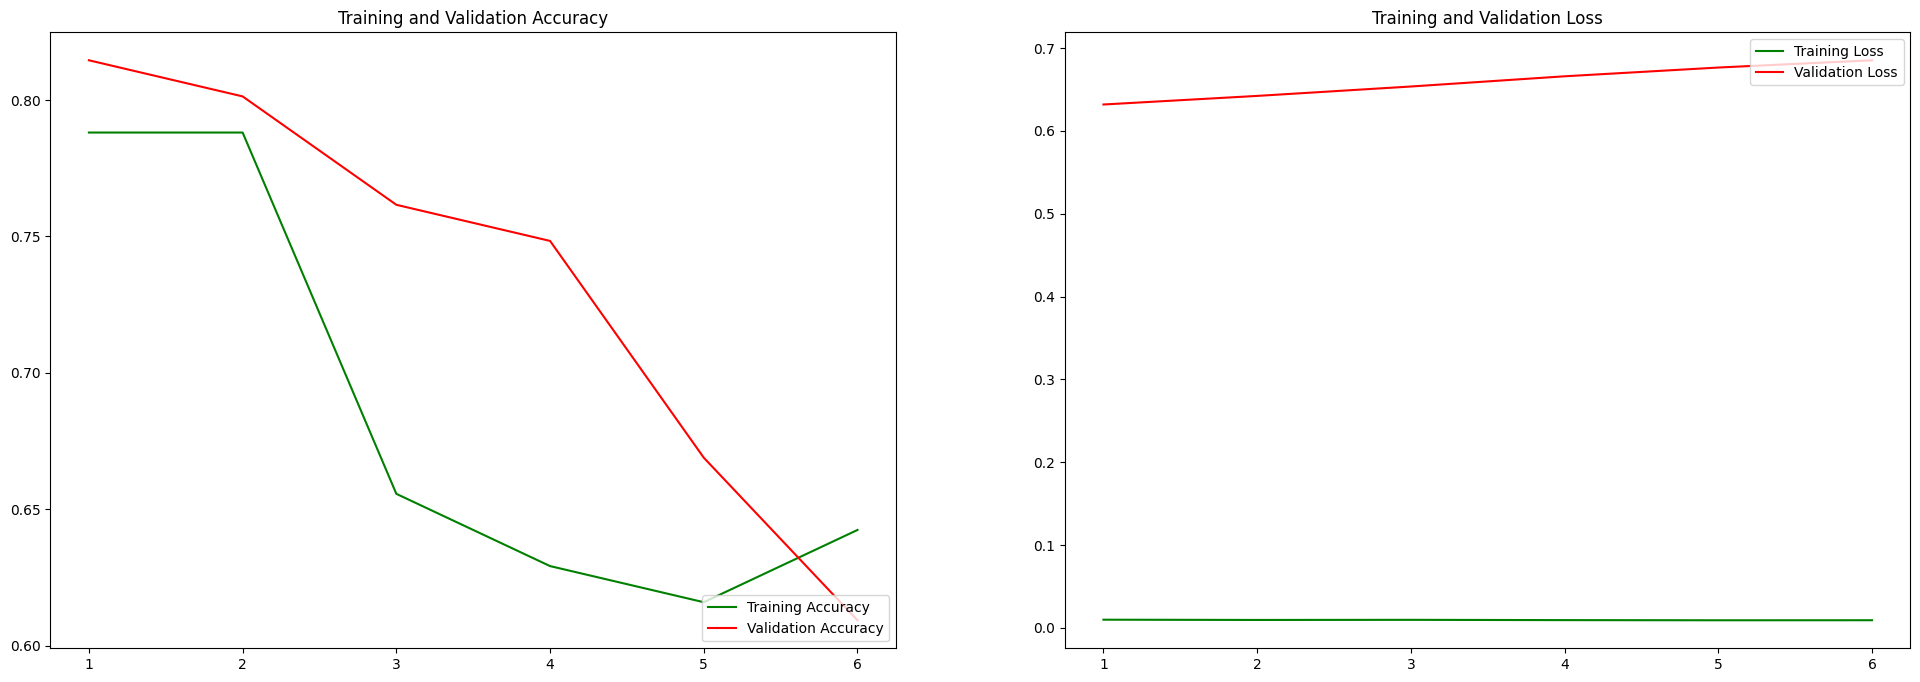

Validation Binary Accuracy is: 0.81
1/1 [==============================] - 0s 249ms/step - loss: 0.6240 - binary_accuracy: 0.8344
Testing Binary Accuracy is: 0.83


In [199]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

1/1 [==============================] - 0s 401ms/step


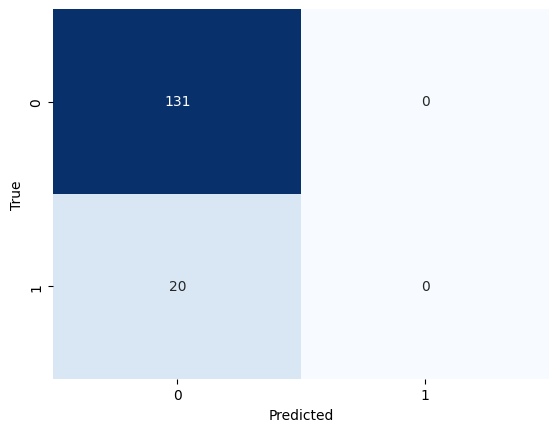

1/1 [==============================] - 0s 40ms/step
              precision   recall  f1-score    support
0              0.867550  1.00000  0.929078  131.00000
1              0.000000  0.00000  0.000000   20.00000
accuracy       0.867550  0.86755  0.867550    0.86755
macro avg      0.433775  0.50000  0.464539  151.00000
weighted avg   0.752642  0.86755  0.806021  151.00000
1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


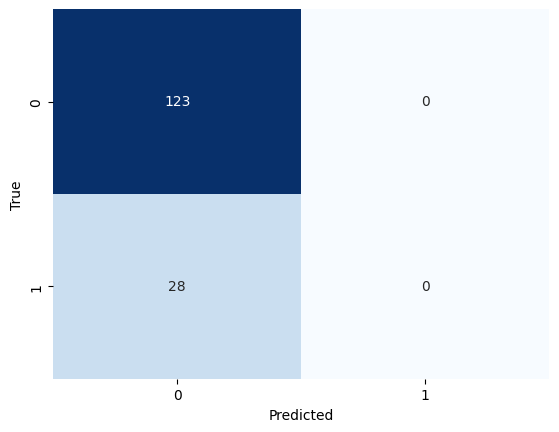

1/1 [==============================] - 0s 40ms/step
              precision   recall  f1-score    support
0              0.814570  1.00000  0.897810  123.00000
1              0.000000  0.00000  0.000000   28.00000
accuracy       0.814570  0.81457  0.814570    0.81457
macro avg      0.407285  0.50000  0.448905  151.00000
weighted avg   0.663524  0.81457  0.731329  151.00000
1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


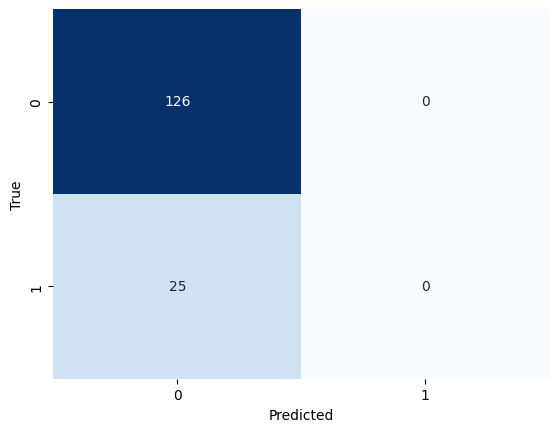

1/1 [==============================] - 0s 35ms/step
              precision    recall  f1-score     support
0              0.834437  1.000000  0.909747  126.000000
1              0.000000  0.000000  0.000000   25.000000
accuracy       0.834437  0.834437  0.834437    0.834437
macro avg      0.417219  0.500000  0.454874  151.000000
weighted avg   0.696285  0.834437  0.759127  151.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [200]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

In [201]:
def build_cpx_lstm_model_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, BatchNormalization
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  x = LSTM(lstm_units, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True)(inputs)

  x = LSTM(lstm_units//2, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True,
        dropout=0.5)(x) # Dropout

  x = BatchNormalization()(x)

  x = LSTM(lstm_units//2, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True,
        dropout=0.5)(x) # Dropout

  x = BatchNormalization()(x)

  outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [202]:
# Parameters for fitting and saving model training data
epochs = 200
model_5_filepath = 'models/model_4_conv_lstm.keras'
history_5_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1]# [1, 2, 10, 100, 1000]

In [204]:
# Fit the model and tune hyperparameters
history_5, model_5, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_cpx_lstm_model_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_5_filepath)
# Pickle the Training Fit History
with open(history_5_filepath, 'wb') as file_pi:
    pickle.dump(history_5, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 300, 32)           4736      
                                                                 
 lstm_23 (LSTM)              (None, 300, 16)           3136      
                                                                 
 batch_normalization_6 (Batc  (None, 300, 16)          64        
 hNormalization)                                                 
                                                                 
 lstm_24 (LSTM)              (None, 300, 16)           2112      
                                                                 
 batch_normalization_7 (Batc  (None, 300, 16)          64        
 

ValueError: ignored

In [ ]:
import numpy as np

target = y_train
print(target.shape)
print(np.unique(target))
print("Number of ones:", np.sum(target==1))
print("Number of zeros:", np.sum(target==0))

In [ ]:
# Get the unique values of the 'label' column
label_values = df['label'].unique()

# Check if there are values other than 0 and 1 in the 'label' column
if set(label_values) - {0, 1}:
    print("The 'label' column contains values other than 0 and 1")
else:
    print("The 'label' column contains only 0 and 1")

In [ ]:
# Load and Evaluate Model
model_5, history_5 = evaluate_model(model_5_filepath, 
                         history_5_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_5_evaluation.pdf')

In [ ]:
confusion_matrix_plot(model_5, train_gen, save_file='models/evaluate/model_5_train_confusion_matrix.pdf')
classification_report_output(model_5, train_gen, save_file=None)
confusion_matrix_plot(model_5, val_gen, save_file='models/evaluate/model_5_val_confusion_matrix.pdf')
classification_report_output(model_5, val_gen, save_file=None)
confusion_matrix_plot(model_5, test_gen, save_file='models/evaluate/model_5_test_confusion_matrix.pdf')
classification_report_output(model_5, test_gen, save_file=None)

In [205]:
# Model 6: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [206]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [207]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 300, 4)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          9472      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_29 (Dense)            (None, 75)                4875      
                                                                 
 dense_30 (Dense)            (None, 1)                 76        
                                                                 
T

1/1 [==============================] - 2s 2s/step - loss: 0.6950 - binary_accuracy: 0.5232


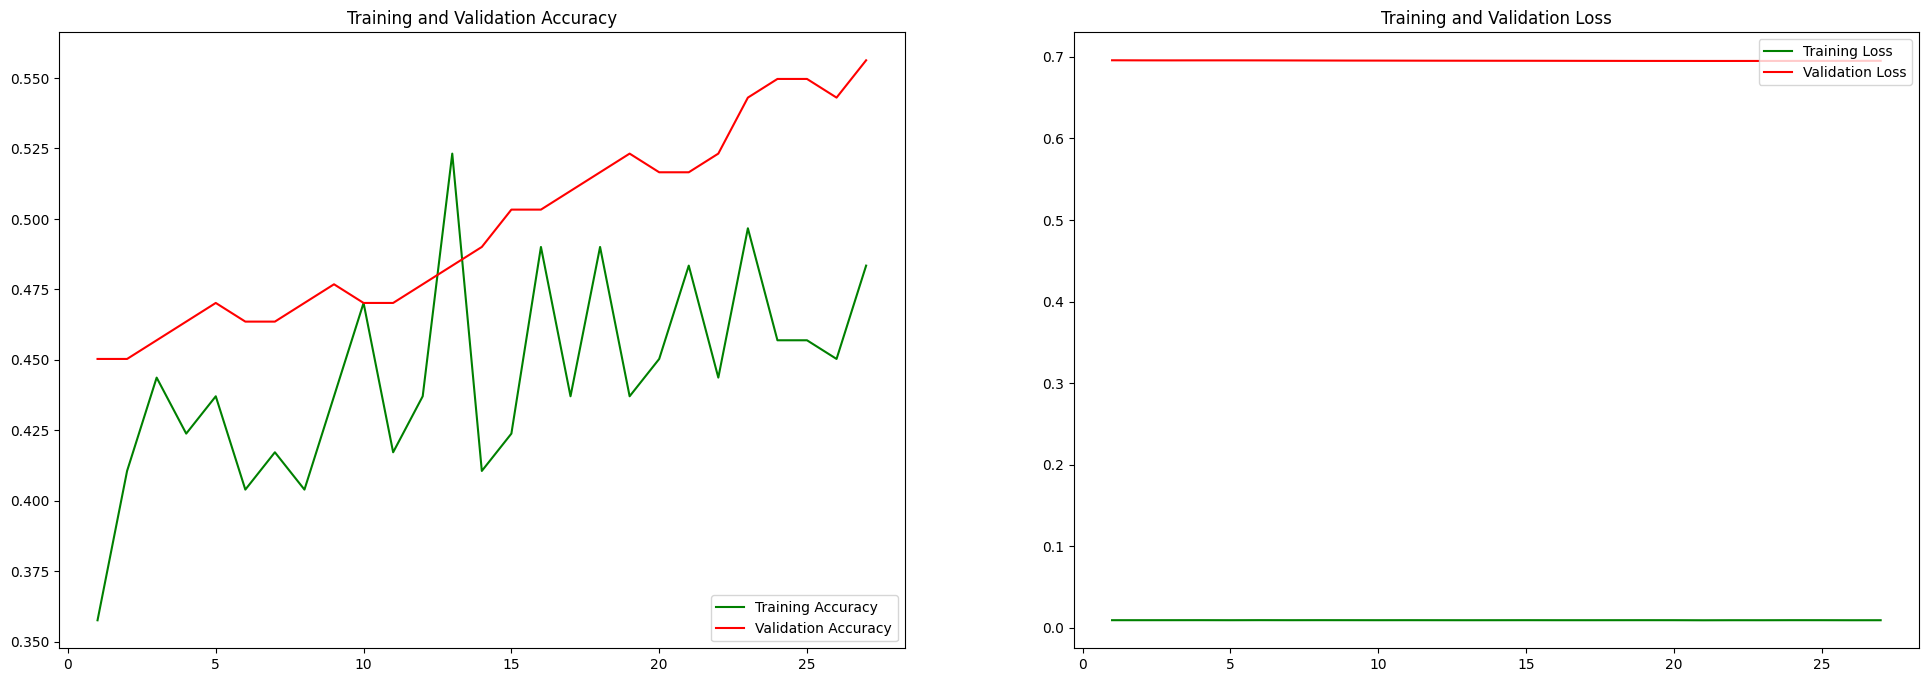

Validation Binary Accuracy is: 0.52
1/1 [==============================] - 0s 380ms/step - loss: 0.6958 - binary_accuracy: 0.5166
Testing Binary Accuracy is: 0.52


In [208]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

1/1 [==============================] - 1s 1s/step


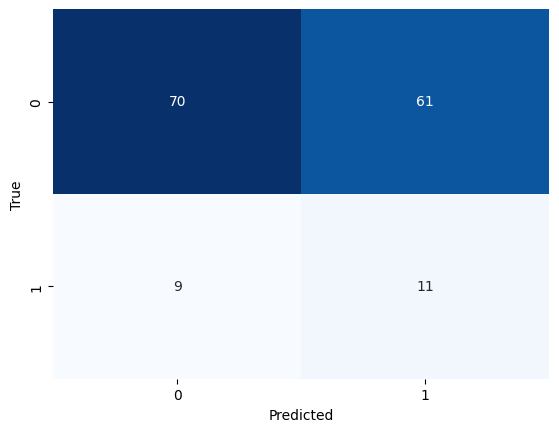

1/1 [==============================] - 0s 55ms/step
              precision    recall  f1-score     support
0              0.886076  0.534351  0.666667  131.000000
1              0.152778  0.550000  0.239130   20.000000
accuracy       0.536424  0.536424  0.536424    0.536424
macro avg      0.519427  0.542176  0.452899  151.000000
weighted avg   0.788950  0.536424  0.610039  151.000000
1/1 [==============================] - 0s 51ms/step


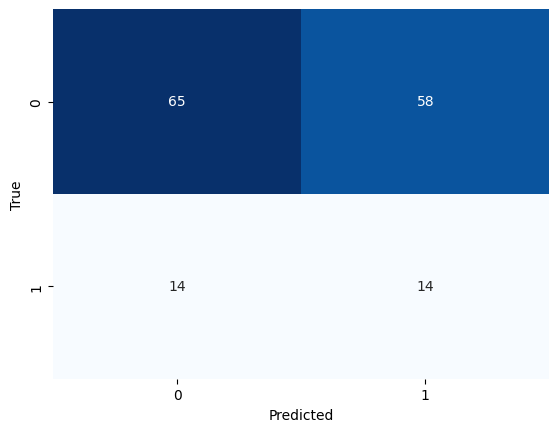

1/1 [==============================] - 0s 50ms/step
              precision    recall  f1-score     support
0              0.822785  0.528455  0.643564  123.000000
1              0.194444  0.500000  0.280000   28.000000
accuracy       0.523179  0.523179  0.523179    0.523179
macro avg      0.508615  0.514228  0.461782  151.000000
weighted avg   0.706271  0.523179  0.576148  151.000000
1/1 [==============================] - 0s 48ms/step


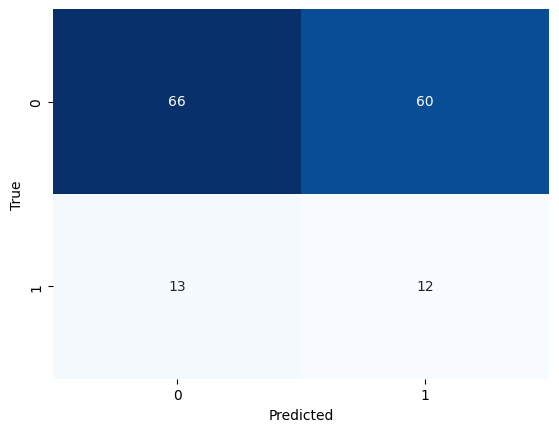

1/1 [==============================] - 0s 50ms/step
              precision    recall  f1-score     support
0              0.835443  0.523810  0.643902  126.000000
1              0.166667  0.480000  0.247423   25.000000
accuracy       0.516556  0.516556  0.516556    0.516556
macro avg      0.501055  0.501905  0.445663  151.000000
weighted avg   0.724718  0.516556  0.578260  151.000000


In [209]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

In [210]:
'''
Model_7: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)

# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 300, 4)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 300, 4)      8           ['input_24[0][0]']               
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 300, 4)      19460       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                           

In [211]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

In [212]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

Epoch 1/200
1/1 [==============================] - 16s 16s/step - loss: 0.6710 - binary_accuracy: 0.1325 - val_loss: 0.6668 - val_binary_accuracy: 0.1854
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.6616 - binary_accuracy: 0.1325 - val_loss: 0.6620 - val_binary_accuracy: 0.1854
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.6618 - binary_accuracy: 0.1325 - val_loss: 0.6579 - val_binary_accuracy: 0.1854
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.6521 - binary_accuracy: 0.1325 - val_loss: 0.6539 - val_binary_accuracy: 0.1854
Epoch 5/200
1/1 [==============================] - 2s 2s/step - loss: 0.6609 - binary_accuracy: 0.1325 - val_loss: 0.6500 - val_binary_accuracy: 0.1854
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.6493 - binary_accuracy: 0.1325 - val_loss: 0.6462 - val_binary_accuracy: 0.1854
Epoch 7/200
1/1 [==============================] - 2s 2s/step - loss: 0.6369 - binary_

1/1 [==============================] - 1s 1s/step - loss: 0.4759 - binary_accuracy: 0.1854


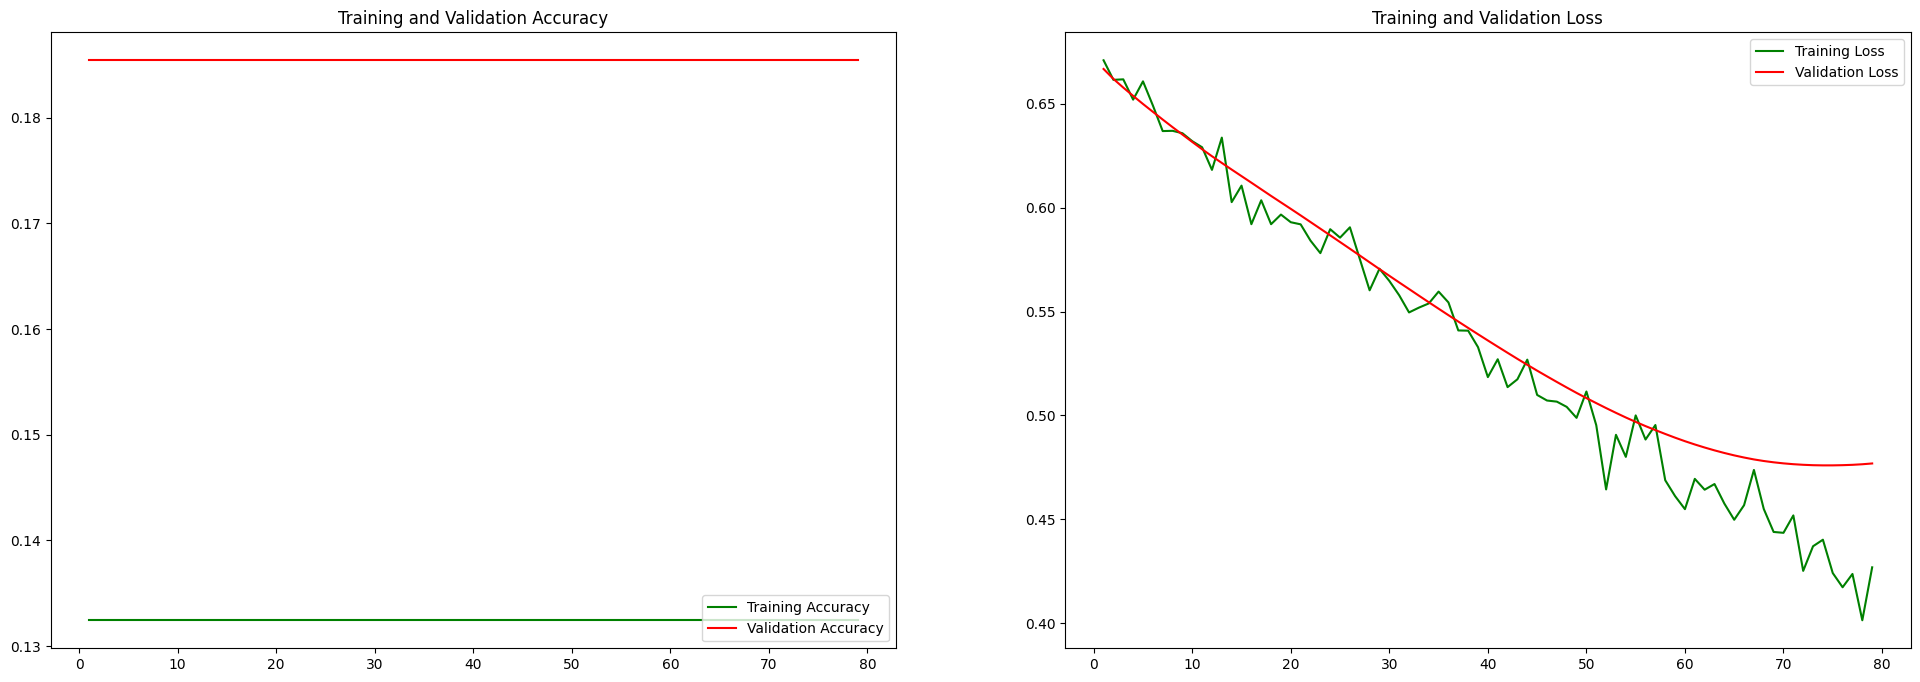

Validation Binary Accuracy is: 0.19
1/1 [==============================] - 1s 520ms/step - loss: 0.4479 - binary_accuracy: 0.1656
Testing Binary Accuracy is: 0.17


In [213]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

1/1 [==============================] - 0s 420ms/step


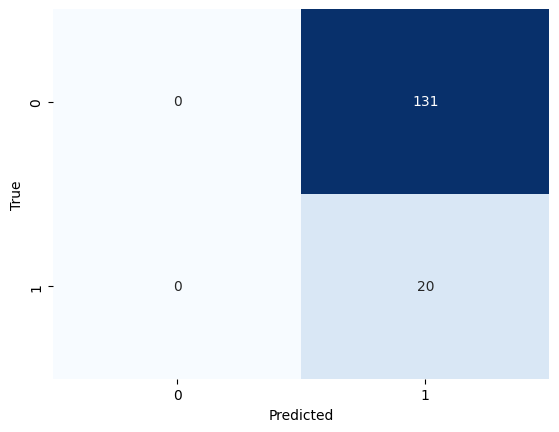

1/1 [==============================] - 0s 39ms/step
              precision   recall  f1-score    support
0              0.000000  0.00000  0.000000  131.00000
1              0.132450  1.00000  0.233918   20.00000
accuracy       0.132450  0.13245  0.132450    0.13245
macro avg      0.066225  0.50000  0.116959  151.00000
weighted avg   0.017543  0.13245  0.030983  151.00000
1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


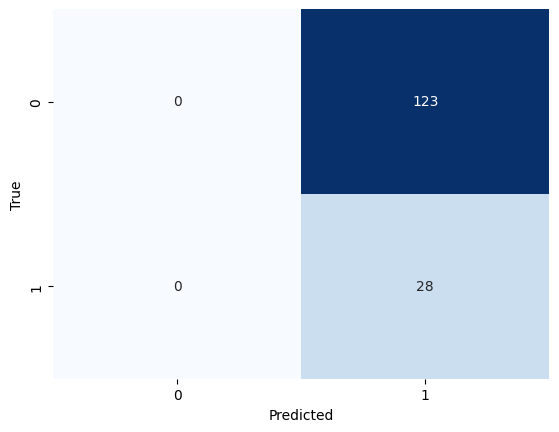

1/1 [==============================] - 0s 41ms/step
              precision   recall  f1-score    support
0              0.000000  0.00000  0.000000  123.00000
1              0.185430  1.00000  0.312849   28.00000
accuracy       0.185430  0.18543  0.185430    0.18543
macro avg      0.092715  0.50000  0.156425  151.00000
weighted avg   0.034384  0.18543  0.058012  151.00000
1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


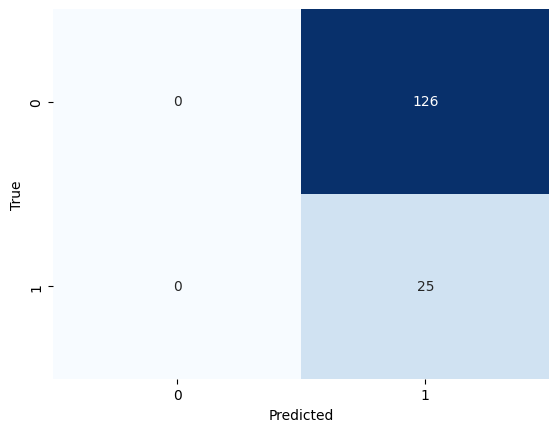

1/1 [==============================] - 0s 32ms/step
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000  126.000000
1              0.165563  1.000000  0.284091   25.000000
accuracy       0.165563  0.165563  0.165563    0.165563
macro avg      0.082781  0.500000  0.142045  151.000000
weighted avg   0.027411  0.165563  0.047035  151.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [214]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

In [215]:
# XGBoost and Random Forests
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [216]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_2d, y_train)

# Print the best hyperparameters and the corresponding validation accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Validation accuracy:", grid_search.best_score_)

y_train_pred = grid_search.predict(X_train_2d)
y_val_pred = grid_search.predict(X_val_2d)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
Validation accuracy: 0.8609150326797385
Train accuracy: 1.0
Validation accuracy: 0.7350993377483444


In [217]:
# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

Confusion matrix (training set):
 [[131   0]
 [  0  20]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00        20

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151

Confusion matrix (validation set):
 [[107  16]
 [ 24   4]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       123
           1       0.20      0.14      0.17        28

    accuracy                           0.74       151
   macro avg       0.51      0.51      0.50       151
weighted avg       0.70      0.74      0.72       151



In [218]:
#Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_2d, y_train)

y_train_pred = rf_model.predict(X_train_2d)
y_val_pred = rf_model.predict(X_val_2d)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

Train accuracy: 1.0
Validation accuracy: 0.7350993377483444


In [219]:
# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

Confusion matrix (training set):
 [[131   0]
 [  0  20]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00        20

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151

Confusion matrix (validation set):
 [[107  16]
 [ 24   4]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       123
           1       0.20      0.14      0.17        28

    accuracy                           0.74       151
   macro avg       0.51      0.51      0.50       151
weighted avg       0.70      0.74      0.72       151

